In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
import pandas as pd
from datasets import Dataset, DatasetDict
import json

In [2]:
with open('./party_lst.json') as json_file:
    parties = json.load(json_file)
parties

['Socialdemokratiet',
 'Venstre',
 'Socialistisk Folkeparti',
 'Det Radikale Venstre',
 'Enhedslisten',
 'Det Konservative Folkeparti',
 'Dansk Folkeparti',
 'Liberal Alliance',
 'Alternativet']

## Flow for each party

### One by one

In [3]:
party = "Socialdemokratiet"

In [4]:
df_train = pd.read_csv("./by_party_train/" + party + ".csv")
df_test = pd.read_csv("./by_party_test/" + party + ".csv")
df_train.head(2)

,Unnamed: 0,Absent,Against,For,Neutral,parties,description,date
0,1,18,27,0,0,Socialdemokratiet (S),"Formålet med beslutningsforslaget var, at rege...",2010-05-06
1,0,19,0,30,0,Socialdemokratiet (S),"Regeringen (Socialdemokratiet), Radikale Venst...",2021-02-13


In [5]:
def preprocess_vote(df):
  
  df['label'] = df.apply(lambda x: 1 if x['Neutral']<x['Against']>x['For'] else 0 if x['Neutral']<x['For']>x['Against'] else None, axis=1)

  df.rename(columns={'description':'text'}, inplace=True)
  df = df[['text', 'label']]
  df = df.dropna()
  df['label'] = df.apply(lambda x: int(x['label']), axis=1)

  return df

## Note "Against" = 1

In [6]:
df_train = preprocess_vote(df_train)
df_test = preprocess_vote(df_test)
df_train.head(2)

,text,label
0,"Formålet med beslutningsforslaget var, at rege...",1
1,"Regeringen (Socialdemokratiet), Radikale Venst...",0


In [7]:
train_set = Dataset.from_pandas(df_train, preserve_index=True)
test_set = Dataset.from_pandas(df_test, preserve_index=True)
dataset = DatasetDict({'train':train_set,
                        'test':test_set})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 281
    })
    test: Dataset({
        features: ['text', 'label', '__index_level_0__'],
        num_rows: 70
    })
})

In [8]:
#Models
klimaBERT = "/klimaBERTe4_v2.1"
checkpoint = klimaBERT

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [9]:
def tokenize(batch):
    tokenized_batch = tokenizer(batch['text'], padding=True, truncation=True, max_length=512)
    return tokenized_batch

tokenized_datasets = dataset.map(tokenize, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

100%|██████████| 1/1 [00:00<00:00, 29.41ba/s]


In [10]:
## Steps for processing data
tokenized_datasets = tokenized_datasets.remove_columns(["text"])

## Rename label column to labels, if not already done
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")

tokenized_datasets.set_format("torch")
tokenized_datasets.column_names
## Our model needs columns that it already knows (the 4 below, NOT any custom columns like "text"):
#['labels', 'input_ids', 'token_type_ids', 'attention_mask']

{'train': ['labels',
  '__index_level_0__',
  'input_ids',
  'token_type_ids',
  'attention_mask'],
 'test': ['labels',
  '__index_level_0__',
  'input_ids',
  'token_type_ids',
  'attention_mask']}

In [11]:
from datasets import load_metric
from datasets import load_metric
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    roc_auc = roc_auc_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc_score': roc_auc
    }

In [12]:
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoModelForSequenceClassification

training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch", per_device_train_batch_size=2, num_train_epochs=5, seed=2022)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2) #Change num  of labels if needed

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [13]:
## Set to use GPU
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [14]:
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
C:\Users\COBOD\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 281
  Num Epochs = 5
  Instantaneous batch size per device = 2
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 1
  Total optimization steps = 705
 20%|██        | 141/705 [01:19<04:36,  2.04it/s]The following columns in the evaluation set  don't have a corresponding argument

{'eval_loss': 1.118721604347229, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.0, 'eval_precision': 0.0, 'eval_recall': 0.0, 'eval_roc_auc_score': 0.5, 'eval_runtime': 4.6613, 'eval_samples_per_second': 15.017, 'eval_steps_per_second': 1.931, 'epoch': 1.0}


 40%|████      | 282/705 [02:42<03:27,  2.04it/s]The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70
  Batch size = 8
                                                 
 40%|████      | 282/705 [02:47<03:27,  2.04it/s]

{'eval_loss': 0.8445354104042053, 'eval_accuracy': 0.7428571428571429, 'eval_f1': 0.30769230769230765, 'eval_precision': 0.5, 'eval_recall': 0.2222222222222222, 'eval_roc_auc_score': 0.5726495726495727, 'eval_runtime': 4.6491, 'eval_samples_per_second': 15.057, 'eval_steps_per_second': 1.936, 'epoch': 2.0}


 60%|██████    | 423/705 [04:04<02:18,  2.04it/s]The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70
  Batch size = 8
                                                 
 60%|██████    | 423/705 [04:09<02:18,  2.04it/s]

{'eval_loss': 1.4555116891860962, 'eval_accuracy': 0.6857142857142857, 'eval_f1': 0.4761904761904762, 'eval_precision': 0.4166666666666667, 'eval_recall': 0.5555555555555556, 'eval_roc_auc_score': 0.6431623931623932, 'eval_runtime': 4.7134, 'eval_samples_per_second': 14.851, 'eval_steps_per_second': 1.909, 'epoch': 3.0}


 71%|███████   | 500/705 [04:52<01:54,  1.80it/s]Saving model checkpoint to test-trainer\checkpoint-500
Configuration saved in test-trainer\checkpoint-500\config.json


{'loss': 0.7769, 'learning_rate': 1.4539007092198581e-05, 'epoch': 3.55}


Model weights saved in test-trainer\checkpoint-500\pytorch_model.bin
tokenizer config file saved in test-trainer\checkpoint-500\tokenizer_config.json
Special tokens file saved in test-trainer\checkpoint-500\special_tokens_map.json
 80%|████████  | 564/705 [05:31<01:09,  2.02it/s]The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70
  Batch size = 8
                                                 
 80%|████████  | 564/705 [05:36<01:09,  2.02it/s]

{'eval_loss': 1.251636028289795, 'eval_accuracy': 0.7285714285714285, 'eval_f1': 0.3870967741935484, 'eval_precision': 0.46153846153846156, 'eval_recall': 0.3333333333333333, 'eval_roc_auc_score': 0.5993589743589743, 'eval_runtime': 4.7022, 'eval_samples_per_second': 14.887, 'eval_steps_per_second': 1.914, 'epoch': 4.0}


100%|██████████| 705/705 [06:54<00:00,  2.03it/s]The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 70
  Batch size = 8
                                                 
100%|██████████| 705/705 [06:59<00:00,  2.03it/s]

Training completed. Do not forget to share your model on huggingface.co/models =)


100%|██████████| 705/705 [06:59<00:00,  1.68it/s]

{'eval_loss': 1.5468006134033203, 'eval_accuracy': 0.7, 'eval_f1': 0.39999999999999997, 'eval_precision': 0.4117647058823529, 'eval_recall': 0.3888888888888889, 'eval_roc_auc_score': 0.5982905982905983, 'eval_runtime': 4.6823, 'eval_samples_per_second': 14.95, 'eval_steps_per_second': 1.922, 'epoch': 5.0}
{'train_runtime': 419.5228, 'train_samples_per_second': 3.349, 'train_steps_per_second': 1.68, 'train_loss': 0.6497332525591478, 'epoch': 5.0}


TrainOutput(global_step=705, training_loss=0.6497332525591478, metrics={'train_runtime': 419.5228, 'train_samples_per_second': 3.349, 'train_steps_per_second': 1.68, 'train_loss': 0.6497332525591478, 'epoch': 5.0})

In [16]:
trainer.save_model("models_binary_party/"+party)

Saving model checkpoint to models_binary_party/Socialdemokratiet
Configuration saved in models_binary_party/Socialdemokratiet\config.json
Model weights saved in models_binary_party/Socialdemokratiet\pytorch_model.bin
tokenizer config file saved in models_binary_party/Socialdemokratiet\tokenizer_config.json
Special tokens file saved in models_binary_party/Socialdemokratiet\special_tokens_map.json


##### Metrics

In [28]:
# example of a roc curve for a predictive model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.dummy import DummyClassifier
m = torch.nn.Softmax(dim=-1)

In [24]:

weight_pred = trainer.predict(tokenized_datasets["test"])[0]
weight_for = []
weight_against = []
for input in weight_pred:
    input2 = torch.from_numpy(input)
    (i,k) = m(input2) #i=against, k=for
    weight_for.append(i.item())
    weight_against.append(k.item())

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__. If __index_level_0__ are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 70
  Batch size = 8
36it [04:32,  1.60s/it]

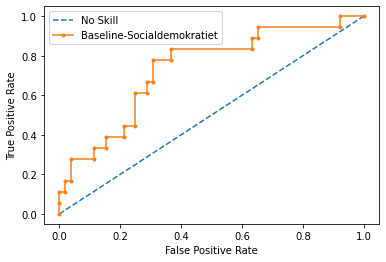

No Skill ROC AUC 0.467
Baseline ROC AUC 0.733


In [31]:
## ROC CURVE
testy = tokenized_datasets["test"]["labels"]

# plot no skill roc curve
model = DummyClassifier(strategy='stratified')
model.fit(tokenized_datasets["train"], tokenized_datasets["train"]["labels"])
yhat = model.predict_proba(tokenized_datasets["test"])
pos_probs = yhat[:, 1]
roc_auc_noskill = roc_auc_score(testy, pos_probs)

pyplot.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# plot the skill curve
# retrieve just the probabilities for the positive class
pos_probs = weight_against
# calculate roc curve for model
fpr, tpr, _ = roc_curve(testy, pos_probs)

# plot model roc curve
pyplot.plot(fpr, tpr, marker='.', label=f'Baseline-{party}')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()

# show the plot
pyplot.show()


roc_auc = roc_auc_score(testy, pos_probs)
print('No Skill ROC AUC %.3f' % roc_auc_noskill)
print('Baseline ROC AUC %.3f' % roc_auc)

In [60]:
y["labels"].sum().item()

18

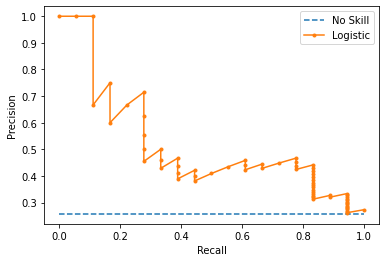

No Skill PR AUC: 0.269
Logistic PR AUC: 0.517


In [67]:
## PR Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
y = tokenized_datasets["test"]
no_of_pos = y["labels"].sum().item()


# calculate the no skill line as the proportion of the positive class
no_skill = (no_of_pos / len(y))
# plot the no skill precision-recall curve
model = DummyClassifier(strategy='stratified')
model.fit(tokenized_datasets["train"], tokenized_datasets["train"]["labels"])
yhat = model.predict_proba(tokenized_datasets["test"])
pos_probs = yhat[:, 1]
# calculate the precision-recall auc
precision, recall, _ = precision_recall_curve(testy, pos_probs)
auc_score_noskill = auc(recall, precision)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')

# calculate model precision-recall curve
pos_probs = weight_against
precision, recall, _ = precision_recall_curve(testy, pos_probs)
# plot the model precision-recall curve
pyplot.plot(recall, precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
auc_score = auc(recall, precision)
print('No Skill PR AUC: %.3f' % auc_score_noskill)
print('Logistic PR AUC: %.3f' % auc_score)

In [ ]:
predictions = trainer.predict(tokenized_datasets["test"])

### Loop for all parties

In [ ]:
for party in parties:
    df_train = pd.read_csv("./by_party_train" + party + ".csv")
    df_test = pd.read_csv("./by_party_test" + party + ".csv")
